In [2]:
import pandas as pd
import numpy as np
from pgmpy.estimators import K2Score
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, BayesianEstimator
import random

def load_data(DATA_CSV):
    D = pd.read_csv(DATA_CSV)
    V = D.columns
    D_shuffled_columns = D.sample(frac=1, axis=1)  # Embaralha as colunas
    V_shuffled_columns = D_shuffled_columns.columns
    #print(f'ARQUIVO: {D}')
    #print(f'VARIÁVEIS: {V}')
    return D, V, D_shuffled_columns, V_shuffled_columns

def calcular_k2(D_shuffled_columns):
    k2score = K2Score(D_shuffled_columns)
    return k2score

def estimar_modelo(D_shuffled_columns):
    k2score = K2Score(D_shuffled_columns)  # Calcula o K2Score com os dados embaralhados
    estimator_k2 = HillClimbSearch(D_shuffled_columns)
    print(estimator_k2)  # Usa os dados embaralhados para a busca
    max_possible_edges = len(V_shuffled_columns) * (len(V_shuffled_columns) - 1) / 2
    max_iter = min(max_possible_edges, 1000)
    best_model = estimator_k2.estimate(scoring_method='k2score', max_indegree=4, max_iter=max_iter)
    k2_score = k2score.score(best_model)  # Calcula o score com os dados embaralhados
    return best_model, k2_score

'''def estimar_modelo(D_shuffled_columns):
    k2score = K2Score(D_shuffled_columns)
    best_score = float("-inf")
    best_model = None

    # Teste diferentes ordens de variáveis e escolha a que maximiza o K2Score
    for i in range(10):  # Teste 10 ordens aleatórias diferentes
        random_order = random.sample(D_shuffled_columns.columns.tolist(), len(D_shuffled_columns.columns))
        estimator_k2 = HillClimbSearch(D_shuffled_columns[random_order])
        model = estimator_k2.estimate(scoring_method='k2score', max_indegree=4, max_iter=1000)
        score = k2score.score(model)
        print(f"Ordem[{random_order}]: Score:", end=" ")
        print(score)
        print('------------------------------------')
        if score > best_score:
            best_score = score
            best_model = model

    return best_model, best_score'''

def tabular_cpd(best_model, D_shuffled_columns):
    bayesian_network = BayesianNetwork(best_model)
    estimator = BayesianEstimator(bayesian_network, D_shuffled_columns)
    cpds = []
    for node in bayesian_network.nodes():
        cpd = estimator.estimate_cpd(node)
        cpds.append(cpd)
    return cpds, bayesian_network

# Caminho do arquivo CSV original
DATA_CSV = 'contact-lenses.csv'

# Carregar dados
D, V, D_shuffled_columns, V_shuffled_columns = load_data(DATA_CSV)


# Estima a estrutura do modelo com o K2
#print(f'Ordem das variáveis antes de estimar: {D}')
print(f'Ordem das variáveis antes de estimar: {V}')
print('---------------- ESTIMANDO ----------------')
print(f'Arquivo com a ordem aleatória para estimar')
print(D_shuffled_columns)
print(f'Ordem das variáveis aleatórias para estimar: {V_shuffled_columns}')
best_model, k2_score = estimar_modelo(D_shuffled_columns)
print(f'Melhor modelo: {best_model}')
print(f'Valor de Score: {k2_score}')


# Exibe a estrutura do modelo
structure = (best_model.edges)
print(f'Estrutura da rede: {structure}')

# Estima as CPDs e passa a bayesian_network
cpds, bayesian_network = tabular_cpd(best_model, D_shuffled_columns)
print(f'CPDs: {cpds}')
print(f'Bayesian Network: {bayesian_network}')


Ordem das variáveis antes de estimar: Index(['age', 'spectacle-prescrip', 'astigmatism', 'tear-prod-rate',
       'contact-lenses'],
      dtype='object')
---------------- ESTIMANDO ----------------
Arquivo com a ordem aleatória para estimar
               age spectacle-prescrip contact-lenses tear-prod-rate  \
0            young              myope           none        reduced   
1            young              myope           soft         normal   
2            young              myope           none        reduced   
3            young              myope           hard         normal   
4            young       hypermetrope           none        reduced   
5            young       hypermetrope           soft         normal   
6            young       hypermetrope           none        reduced   
7            young       hypermetrope           hard         normal   
8   pre-presbyopic              myope           none        reduced   
9   pre-presbyopic              myope           

 20%|██        | 2/10 [00:00<00:00, 19.11it/s]

Melhor modelo: DAG with 5 nodes and 2 edges
Valor de Score: -98.72503647411926
Estrutura da rede: [('contact-lenses', 'tear-prod-rate'), ('contact-lenses', 'astigmatism')]
CPDs: [<TabularCPD representing P(age:3) at 0x22c18ecfd10>, <TabularCPD representing P(spectacle-prescrip:2) at 0x22c18db3e90>, <TabularCPD representing P(contact-lenses:3) at 0x22c18ecfc50>, <TabularCPD representing P(tear-prod-rate:2 | contact-lenses:3) at 0x22c18ecf320>, <TabularCPD representing P(astigmatism:2 | contact-lenses:3) at 0x22c18ecfef0>]
Bayesian Network: BayesianNetwork with 5 nodes and 2 edges


In [34]:
import pandas as pd
import numpy as np
from pgmpy.estimators import K2Score
from pgmpy.models import BayesianModel
from pgmpy.estimators import HillClimbSearch, BayesianEstimator
import random

def load_data(DATA_CSV):
    D = pd.read_csv(DATA_CSV)
    V = D.columns
    D_shuffled_columns = D.sample(frac=1, axis=1)  # Embaralha as colunas
    V_shuffled_columns = D_shuffled_columns.columns
    return D, V, D_shuffled_columns, V_shuffled_columns

def estimar_modelo(D_shuffled_columns):
    max_possible_edges = len(V_shuffled_columns) * (len(V_shuffled_columns) - 1) / 2
    max_iter = min(max_possible_edges, 1000)
    
    all_models = []
    # Avalia diferentes ordens de variáveis
    for i in range(10):  # Teste 10 ordens aleatórias diferentes
        k2score = K2Score(D_shuffled_columns)  # Calcula o K2Score com os dados embaralhados
        estimator_k2 = HillClimbSearch(D_shuffled_columns)
        random_order = random.sample(D_shuffled_columns.columns.tolist(), len(D_shuffled_columns.columns))
        print(f'Ordem aleatória: {random_order}')
        estimator_k2 = HillClimbSearch(D_shuffled_columns[random_order])
        print(f'Ordem das variáveis após passar pelo estimador HillClimb: {estimator_k2.variables}') #print para ver se a ordem das variáveis estão indo corretas
        
        #O erro está aqui, na hora de estimar o model

        model = estimator_k2.estimate(scoring_method='k2score', max_indegree=4, max_iter=max_iter)
        print(f'Estrutura gerada após estimar: {model.edges}')
        k2score = K2Score(D_shuffled_columns[random_order])
        score = k2score.score(model)
        print(f'Valor de K2: {score}')
        all_models.append((model, score))
        print('--------------------------------------------------------------------------')
        
    return all_models



def tabular_cpd(best_model, D_shuffled_columns):
    bayesian_network = BayesianNetwork(best_model)
    estimator = BayesianEstimator(bayesian_network, D_shuffled_columns)
    cpds = []
    for node in bayesian_network.nodes():
        cpd = estimator.estimate_cpd(node)
        cpds.append(cpd)
    return cpds, bayesian_network

# Caminho do arquivo CSV original
DATA_CSV = 'contact-lenses.csv'

# Carregar dados
D, V, D_shuffled_columns, V_shuffled_columns = load_data(DATA_CSV)

# Estima os modelos e obtém a lista de todos os modelos gerados
all_models = estimar_modelo(D_shuffled_columns)

# Itera sobre a lista de modelos e imprime as estruturas e os scores
for idx, (model, score) in enumerate(all_models):
    print(f"Modelo {idx + 1}:")
    print("Estrutura:", model.edges)
    print("Score:", score)
    print("--------------------")


Ordem aleatória: ['spectacle-prescrip', 'age', 'tear-prod-rate', 'contact-lenses', 'astigmatism']
Ordem das variáveis após passar pelo estimador HillClimb: ['spectacle-prescrip', 'age', 'tear-prod-rate', 'contact-lenses', 'astigmatism']


 20%|██        | 2/10 [00:00<00:00, 20.78it/s]


Estrutura gerada após estimar: [('contact-lenses', 'tear-prod-rate'), ('contact-lenses', 'astigmatism')]
Valor de K2: -98.72503647411929
--------------------------------------------------------------------------
Ordem aleatória: ['astigmatism', 'spectacle-prescrip', 'contact-lenses', 'tear-prod-rate', 'age']
Ordem das variáveis após passar pelo estimador HillClimb: ['astigmatism', 'spectacle-prescrip', 'contact-lenses', 'tear-prod-rate', 'age']


 20%|██        | 2/10 [00:00<00:00, 27.61it/s]


Estrutura gerada após estimar: [('contact-lenses', 'tear-prod-rate'), ('contact-lenses', 'astigmatism')]
Valor de K2: -98.72503647411928
--------------------------------------------------------------------------
Ordem aleatória: ['age', 'astigmatism', 'contact-lenses', 'spectacle-prescrip', 'tear-prod-rate']
Ordem das variáveis após passar pelo estimador HillClimb: ['age', 'astigmatism', 'contact-lenses', 'spectacle-prescrip', 'tear-prod-rate']


 20%|██        | 2/10 [00:00<00:00, 22.42it/s]


Estrutura gerada após estimar: [('contact-lenses', 'tear-prod-rate'), ('contact-lenses', 'astigmatism')]
Valor de K2: -98.72503647411929
--------------------------------------------------------------------------
Ordem aleatória: ['astigmatism', 'spectacle-prescrip', 'contact-lenses', 'age', 'tear-prod-rate']
Ordem das variáveis após passar pelo estimador HillClimb: ['astigmatism', 'spectacle-prescrip', 'contact-lenses', 'age', 'tear-prod-rate']


 20%|██        | 2/10 [00:00<00:00, 19.06it/s]


Estrutura gerada após estimar: [('contact-lenses', 'tear-prod-rate'), ('contact-lenses', 'astigmatism')]
Valor de K2: -98.72503647411929
--------------------------------------------------------------------------
Ordem aleatória: ['tear-prod-rate', 'contact-lenses', 'spectacle-prescrip', 'age', 'astigmatism']
Ordem das variáveis após passar pelo estimador HillClimb: ['tear-prod-rate', 'contact-lenses', 'spectacle-prescrip', 'age', 'astigmatism']


 20%|██        | 2/10 [00:00<00:00, 10.77it/s]


Estrutura gerada após estimar: [('contact-lenses', 'tear-prod-rate'), ('contact-lenses', 'astigmatism')]
Valor de K2: -98.72503647411929
--------------------------------------------------------------------------
Ordem aleatória: ['contact-lenses', 'astigmatism', 'spectacle-prescrip', 'age', 'tear-prod-rate']
Ordem das variáveis após passar pelo estimador HillClimb: ['contact-lenses', 'astigmatism', 'spectacle-prescrip', 'age', 'tear-prod-rate']


 20%|██        | 2/10 [00:00<00:00, 27.35it/s]


Estrutura gerada após estimar: [('contact-lenses', 'tear-prod-rate'), ('contact-lenses', 'astigmatism')]
Valor de K2: -98.72503647411929
--------------------------------------------------------------------------
Ordem aleatória: ['tear-prod-rate', 'spectacle-prescrip', 'astigmatism', 'age', 'contact-lenses']
Ordem das variáveis após passar pelo estimador HillClimb: ['tear-prod-rate', 'spectacle-prescrip', 'astigmatism', 'age', 'contact-lenses']


 20%|██        | 2/10 [00:00<00:00, 35.09it/s]


Estrutura gerada após estimar: [('contact-lenses', 'tear-prod-rate'), ('contact-lenses', 'astigmatism')]
Valor de K2: -98.72503647411928
--------------------------------------------------------------------------
Ordem aleatória: ['contact-lenses', 'age', 'spectacle-prescrip', 'astigmatism', 'tear-prod-rate']
Ordem das variáveis após passar pelo estimador HillClimb: ['contact-lenses', 'age', 'spectacle-prescrip', 'astigmatism', 'tear-prod-rate']


 20%|██        | 2/10 [00:00<00:00, 35.39it/s]


Estrutura gerada após estimar: [('contact-lenses', 'tear-prod-rate'), ('contact-lenses', 'astigmatism')]
Valor de K2: -98.72503647411929
--------------------------------------------------------------------------
Ordem aleatória: ['age', 'contact-lenses', 'astigmatism', 'spectacle-prescrip', 'tear-prod-rate']
Ordem das variáveis após passar pelo estimador HillClimb: ['age', 'contact-lenses', 'astigmatism', 'spectacle-prescrip', 'tear-prod-rate']


 20%|██        | 2/10 [00:00<00:00, 20.72it/s]


Estrutura gerada após estimar: [('contact-lenses', 'tear-prod-rate'), ('contact-lenses', 'astigmatism')]
Valor de K2: -98.72503647411929
--------------------------------------------------------------------------
Ordem aleatória: ['age', 'spectacle-prescrip', 'astigmatism', 'tear-prod-rate', 'contact-lenses']
Ordem das variáveis após passar pelo estimador HillClimb: ['age', 'spectacle-prescrip', 'astigmatism', 'tear-prod-rate', 'contact-lenses']


 20%|██        | 2/10 [00:00<00:00, 22.48it/s]

Estrutura gerada após estimar: [('contact-lenses', 'tear-prod-rate'), ('contact-lenses', 'astigmatism')]
Valor de K2: -98.72503647411928
--------------------------------------------------------------------------
Modelo 1:
Estrutura: [('contact-lenses', 'tear-prod-rate'), ('contact-lenses', 'astigmatism')]
Score: -98.72503647411929
--------------------
Modelo 2:
Estrutura: [('contact-lenses', 'tear-prod-rate'), ('contact-lenses', 'astigmatism')]
Score: -98.72503647411928
--------------------
Modelo 3:
Estrutura: [('contact-lenses', 'tear-prod-rate'), ('contact-lenses', 'astigmatism')]
Score: -98.72503647411929
--------------------
Modelo 4:
Estrutura: [('contact-lenses', 'tear-prod-rate'), ('contact-lenses', 'astigmatism')]
Score: -98.72503647411929
--------------------
Modelo 5:
Estrutura: [('contact-lenses', 'tear-prod-rate'), ('contact-lenses', 'astigmatism')]
Score: -98.72503647411929
--------------------
Modelo 6:
Estrutura: [('contact-lenses', 'tear-prod-rate'), ('contact-lenses',

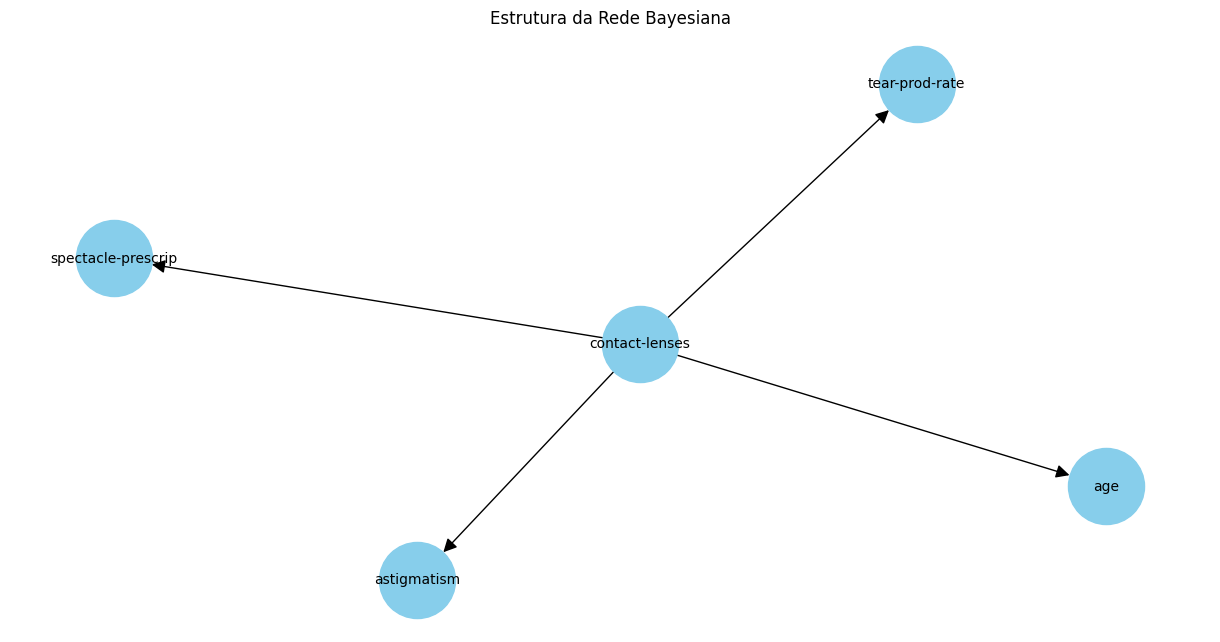

In [8]:
import matplotlib.pyplot as plt
import networkx as nx

# Criar um objeto de grafo direcionado
G = nx.DiGraph()

# Adicionar arestas ao grafo com base na estrutura do modelo
G.add_edges_from(best_model.edges())

# Plotar o grafo
plt.figure(figsize=(12, 6))
pos = nx.spring_layout(G)  # Define a posição dos nós
nx.draw(G, pos, with_labels=True, node_size=3000, node_color="skyblue", font_size=10, arrowsize=20)
plt.title("Estrutura da Rede Bayesiana")
plt.show()